In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import files
uploaded = files.upload()

Saving sherlockholmes.txt to sherlockholmes.txt


**1. Building the Dataset from .txt**

In [3]:
file = open("sherlockholmes.txt", "r", encoding = "utf8")
old_lines = []
for i in file:
    old_lines.append(i)

lines = []
z = len(old_lines)
for i in range(0,len(old_lines)):
  if i>57 and i<z-373:
    lines.append(old_lines[i])

data = ""
for i in lines:
  data = ' '. join(lines) 

data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','').replace('I.','').replace('_','')

data = data.split()
data = ' '.join(data)
print("Total Characters in Dataset = " + str(len(data)))
print(data[0:500])

Total Characters in Dataset = 553406
A SCANDAL IN BOHEMIA To Sherlock Holmes she is always the woman. I have seldom heard him mention her under any other name. In his eyes she eclipses and predominates the whole of her sex. It was not that he felt any emotion akin to love for Irene Adler. All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. He was, I take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a


**2. Vectorization Method - Bag of Words**

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]

vocab_size = len(tokenizer.word_index) + 1
print("No. of Words in our Vocabulary = " + str(vocab_size))

sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("No. of 3-word sequences are =", len(sequences))
sequences = np.array(sequences)

No. of Words in our Vocabulary = 8335
No. of 3-word sequences are = 105559


In [5]:
#building training sets
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

y = to_categorical(y, num_classes=vocab_size)

**3. Building and Training Model**

In [6]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             83350     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 8335)              8343335   
                                                                 
Total params: 21,475,685
Trainable params: 21,475,685
Non-trainable params: 0
_________________________________________________________________


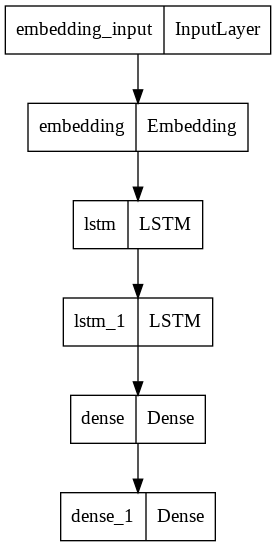

In [8]:
plot_model(model, to_file='plot.png', show_layer_names=True)

In [ ]:
checkpoint = ModelCheckpoint("final_model0.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X, y, epochs=20, batch_size=64, callbacks=[checkpoint])

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

Epoch 1/20
1650/1650 [==============================] - ETA: 0s - loss: 6.3383 - accuracy: 0.0678
Epoch 1: loss improved from inf to 6.33833, saving model to final_model0.h5
1650/1650 [==============================] - 956s 577ms/step - loss: 6.3383 - accuracy: 0.0678
Epoch 2/20
1650/1650 [==============================] - ETA: 0s - loss: 5.7637 - accuracy: 0.1018
Epoch 2: loss improved from 6.33833 to 5.76365, saving model to final_model0.h5
1650/1650 [==============================] - 944s 572ms/step - loss: 5.7637 - accuracy: 0.1018
Epoch 3/20
 883/1650 [===============>..............] - ETA: 7:11 - loss: 5.4694 - accuracy: 0.1209

**4. Predicting the word.**

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('drive/MyDrive/Lab/SEM7/ROSPLab/next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""
  
  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break
  
  print(predicted_word)
  return predicted_word

text = input("Enter your line: ")
  
if text == "0":
    print("Execution completed.....")
else:
    text = text.split(" ")
    text = text[-3:]
    print(text)
        
Predict_Next_Words(model, tokenizer, text)

Enter your line: sherlock is a 
['is', 'a', '']
Error occurred:  in user code:

    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise Val

KeyboardInterrupt: ignored